# Indian Names Generator:
inspired from Andrej Karpathy and MLP research paper - [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)


In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
#downloading dataset
!wget https://github.com/PranavInani/Macahine-Learning-Projects/blob/main/Indian%20Names%20Generator/Indian_Names.csv

--2024-07-02 12:53:18--  https://github.com/PranavInani/Macahine-Learning-Projects/blob/main/Indian%20Names%20Generator/Indian_Names.csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Indian_Names.csv.1’

Indian_Names.csv.1      [ <=>                ] 406.77K  --.-KB/s    in 0.03s   

2024-07-02 12:53:18 (13.3 MB/s) - ‘Indian_Names.csv.1’ saved [416530]



In [69]:
df = pd.read_csv('Indian_Names.csv', ).dropna()

In [3]:
names = df['Name'].tolist()
len(names)

6485

In [4]:
# removing some special characters
names = [w for w in names if all(ch.isalpha() for ch in w)]
len(names)

6466

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [37]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([38012, 3]) torch.Size([38012])
torch.Size([4767, 3]) torch.Size([4767])
torch.Size([4782, 3]) torch.Size([4782])


In [38]:
g = torch.Generator().manual_seed(1234) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [39]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [40]:
for p in parameters:
  p.requires_grad = True

In [41]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [47]:
#lri = []
lossi = []
stepi = []

In [56]:
for i in range(121200):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[int(i/10)]
  #lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[int(i/10)])
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

2.044520616531372


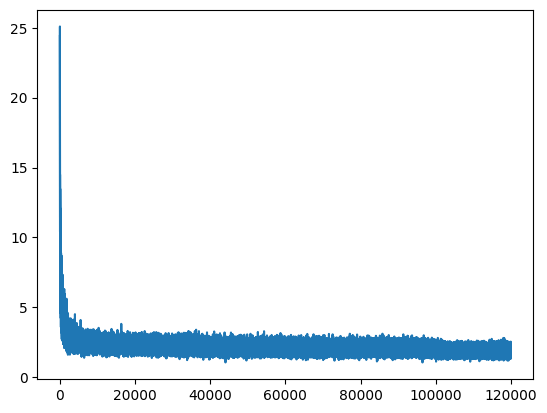

In [49]:
plt.plot(stepi, lossi)

In [57]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.8738, grad_fn=<NllLossBackward0>)

In [58]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1654, grad_fn=<NllLossBackward0>)

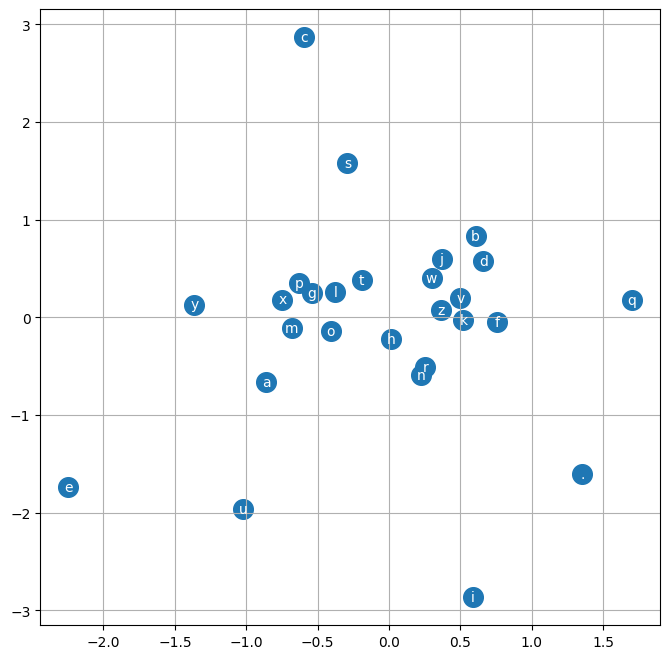

In [52]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [67]:
# sample from the model
g = torch.Generator().manual_seed(5)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

karam.
dipal.
besh.
fafi.
sher.
harvinder.
fhrajni.
nasimrat.
mehan.
ruchsharjinesh.
deenu.
sany.
faramkitdeyjir.
nasangta.
shishantu.
gal.
roop.
girtiaz.
tayata.
mer.
